In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Taxi Trajectory

https://www.kaggle.com/akshaychavan123/taxi-trip-time-prediction

We have provided with the dataset describing a complete year (from 1 july 2013 to 30 june 2014) of the trajectories for all the 442 taxies running in the city of portugal.

We are hired by the transportation industry of portugal and want to predict the total travel time of the trip based on the attributes given in the datasets.
Data Overview

Each data point corresponds to one complete trip. It contains a total 9 features

    TRIP_ID (string) : It contains an unique identifier for each trip
    CALL_TYPE (char) : It identifies the way used to demand this service. It may contain one of three possible values.

                    1. 'A' : if this trip was dispatched from the central
                    2. 'B' : if this trip was demanded directly to a taxi driver on a specific stand
                    3. 'C' : otherwise (i.e. a trip demanded on a random street)

    ORIGIN_CALL (integer) : It contains an unique identifier for each phone number which was used to demand, at least, one service. It identifies the trip’s customer if CALL_TYPE=’A’. Otherwise, it assumes a NULL value
    ORIGIN_STAND (integer): It contains an unique identifier for the taxi stand. It identifies the starting point of the trip if CALL_TYPE=’B’. Otherwise, it assumes a NULL value
    TAXI_ID: (integer): It contains an unique identifier for the taxi driver that performed each trip
    TIMESTAMP (integer) : Unix Timestamp (in seconds). It identifies the trip’s start
    DAYTYPE (char) : It identifies the daytype of the trip’s start. It assumes one of three possible values

                  1. 'B' : if this trip started on a holiday or any other special day (i.e. extending holidays, floating holidays, etc.)
                  2. 'C' : if the trip started on a day before a type-B day
                  3. 'A' : otherwise (i.e. a normal day, workday or weekend)

    MISSING_DATA (Boolean) : It is FALSE when the GPS data stream is complete and TRUE whenever one (or more) locations are missing.
    POLYLINE (String): It contains a list of GPS coordinates (i.e. WGS84 format) mapped as a string.The last list item corresponds to the trip’s destination while the first one represents its start. The beginning and the end of the string are identified with brackets (i.e. [ and ], respectively). Each pair of coordinates is also identified by the same brackets as [LONGITUDE, LATITUDE]. This list contains one pair of coordinates for each 15 seconds of trip. The POLYLINE can have multiple pairs of longitude and latitude

The total travel time of the trip (the prediction target) is defined as the (number of points-1) x 15 seconds. For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds.
Type of Machine Learning task :

It is an regression problem where given a set of features we need to predict the total travel time by taxi from starting of ride to the destination in seconds.

Performace Metric

Since it is an regression problem we will use Root Mean Squared error (RMSE) and R-squared as regression metric.

Importing Libraries


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from math import sqrt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from mlxtend.regressor import StackingRegressor

import joblib


**EDA, Data Cleaning and Feature Engineering**

Load the taxi trajectory data from CSV file

In [7]:
df = pd.read_csv('/content/drive/My Drive/taxi_trajectory_data/train.csv')

In [8]:
df.shape

(1710670, 9)

In [9]:
df.columns

Index(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID',
       'TIMESTAMP', 'DAY_TYPE', 'MISSING_DATA', 'POLYLINE'],
      dtype='object')

In [10]:
df.head(10)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."
5,1372636965620000231,C,NaN,NaN,20000231,1372636965,A,False,"[[-8.615502,41.140674],[-8.614854,41.140926],[..."
6,1372637210620000456,C,NaN,NaN,20000456,1372637210,A,False,"[[-8.57952,41.145948],[-8.580942,41.145039],[-..."
7,1372637299620000011,C,NaN,NaN,20000011,1372637299,A,False,"[[-8.617563,41.146182],[-8.617527,41.145849],[..."
8,1372637274620000403,C,NaN,NaN,20000403,1372637274,A,False,"[[-8.611794,41.140557],[-8.611785,41.140575],[..."
9,1372637905620000320,C,NaN,NaN,20000320,1372637905,A,False,"[[-8.615907,41.140557],[-8.614449,41.141088],[..."




Filtering out categorical features.


In [11]:
df.dtypes[df.dtypes == 'object']

CALL_TYPE    object
DAY_TYPE     object
POLYLINE     object
dtype: object

In [12]:
df.isnull().sum()

TRIP_ID               0
CALL_TYPE             0
ORIGIN_CALL     1345900
ORIGIN_STAND     904091
TAXI_ID               0
TIMESTAMP             0
DAY_TYPE              0
MISSING_DATA          0
POLYLINE              0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710670 entries, 0 to 1710669
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   TRIP_ID       int64  
 1   CALL_TYPE     object 
 2   ORIGIN_CALL   float64
 3   ORIGIN_STAND  float64
 4   TAXI_ID       int64  
 5   TIMESTAMP     int64  
 6   DAY_TYPE      object 
 7   MISSING_DATA  bool   
 8   POLYLINE      object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 106.0+ MB


In [14]:
df.describe()

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP
count,1.710670e+06,364770.000000,806579.000000,1.710670e+06,1.710670e+06
mean,1.388622e+18,24490.363018,30.272381,2.000035e+07,1.388622e+09
std,9.180944e+15,19624.290043,17.747840,2.112405e+02,9.180944e+06
min,1.372637e+18,2001.000000,1.000000,2.000000e+07,1.372637e+09
25%,1.380731e+18,6593.000000,15.000000,2.000017e+07,1.380731e+09
50%,1.388493e+18,18755.000000,27.000000,2.000034e+07,1.388493e+09
75%,1.396750e+18,40808.000000,49.000000,2.000052e+07,1.396750e+09
max,1.404173e+18,63884.000000,63.000000,2.000098e+07,1.404173e+09




Describing the categorical features.


In [15]:
df.describe(include = ['object'])

,CALL_TYPE,DAY_TYPE,POLYLINE
count,1710670,1710670,1710670
unique,3,1,1703650
top,B,A,[]
freq,817881,1710670,5901


We can see the DAY_TYPE has only 1 unique value and that is 'A' which means that all the trips are started on normal day or weekend. Also the 5901 observations don't have the POLYLINE values means we cannot calculate the travel time for those trips.

In [16]:
df.sort_values('TIMESTAMP',inplace = True)

In [17]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
577,1372636853620000380,C,NaN,NaN,20000380,1372636853,A,False,"[[-8.610291,41.140746],[-8.6103,41.140755],[-8..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
10,1372636875620000233,C,NaN,NaN,20000233,1372636875,A,False,"[[-8.619894,41.148009],[-8.620164,41.14773],[-..."
64,1372636896620000360,C,NaN,NaN,20000360,1372636896,A,False,"[[-8.617599,41.146137],[-8.617581,41.14593],[-..."


In [18]:
df['year'] = df['TIMESTAMP'].apply(lambda x :datetime.datetime.fromtimestamp(x).year) 
df['month'] = df['TIMESTAMP'].apply(lambda x :datetime.datetime.fromtimestamp(x).month) 
df['month_day'] = df['TIMESTAMP'].apply(lambda x :datetime.datetime.fromtimestamp(x).day) 
df['hour'] = df['TIMESTAMP'].apply(lambda x :datetime.datetime.fromtimestamp(x).hour) 
df['week_day'] = df['TIMESTAMP'].apply(lambda x :datetime.datetime.fromtimestamp(x).weekday()) 

In [19]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,year,month,month_day,hour,week_day
577,1372636853620000380,C,NaN,NaN,20000380,1372636853,A,False,"[[-8.610291,41.140746],[-8.6103,41.140755],[-8...",2013,7,1,0,0
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013,7,1,0,0
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013,7,1,0,0
10,1372636875620000233,C,NaN,NaN,20000233,1372636875,A,False,"[[-8.619894,41.148009],[-8.620164,41.14773],[-...",2013,7,1,0,0
64,1372636896620000360,C,NaN,NaN,20000360,1372636896,A,False,"[[-8.617599,41.146137],[-8.617581,41.14593],[-...",2013,7,1,0,0


Pie chart for the year

([<matplotlib.patches.Wedge at 0x7f597f511d10>,
 [Text(-0.0067795454598015585, 1.0999791078758536, '2013'),
  Text(0.006779648447278292, -1.0999791072411018, '2014')],
 [Text(-0.0036979338871644856, 0.59998860429592, '50.2%'),
  Text(0.003697990062151795, -0.5999886039496919, '49.8%')])

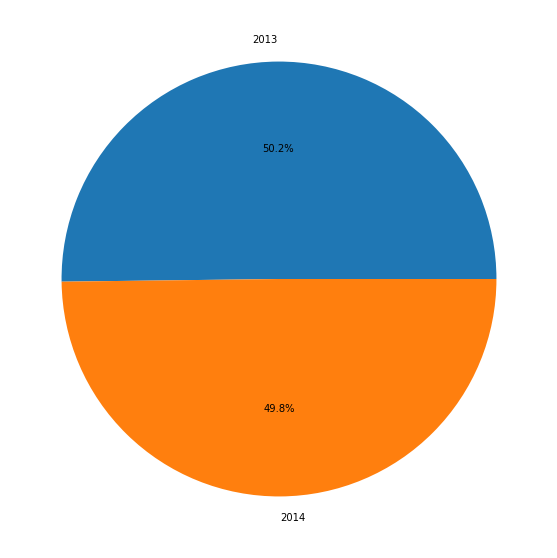

In [20]:
plt.figure(figsize = (10,10))
plt.pie(df['year'].value_counts(), labels = df['year'].value_counts().keys(),autopct = '%.1f%%')

Text(0, 0.5, 'Day')

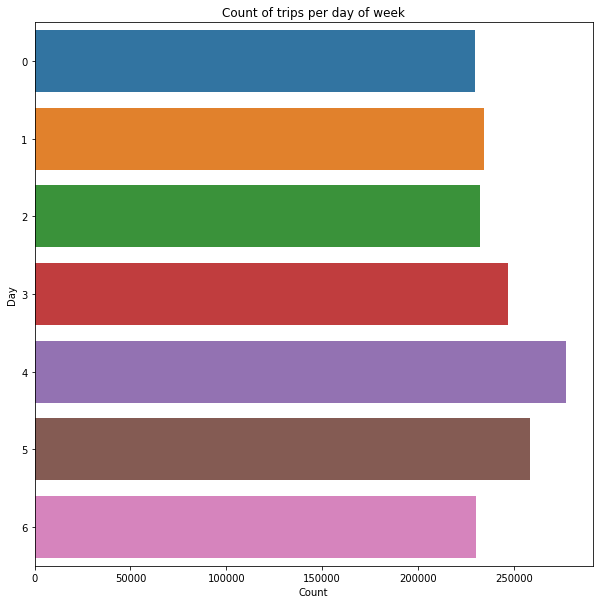

In [21]:
plt.figure(figsize = (10,10))
plt.title('Count of trips per day of week')
sns.countplot(y = 'week_day', data = df)
plt.xlabel('Count')
plt.ylabel('Day')

Text(0, 0.5, 'Month')

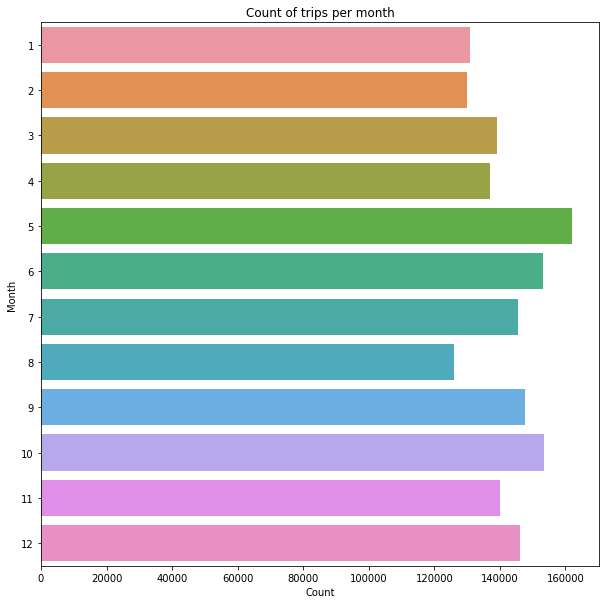

In [22]:
plt.figure(figsize = (10,10))
plt.title('Count of trips per month')
sns.countplot(y = 'month', data = df)
plt.xlabel('Count')
plt.ylabel('Month')

Text(0, 0.5, 'Hours')

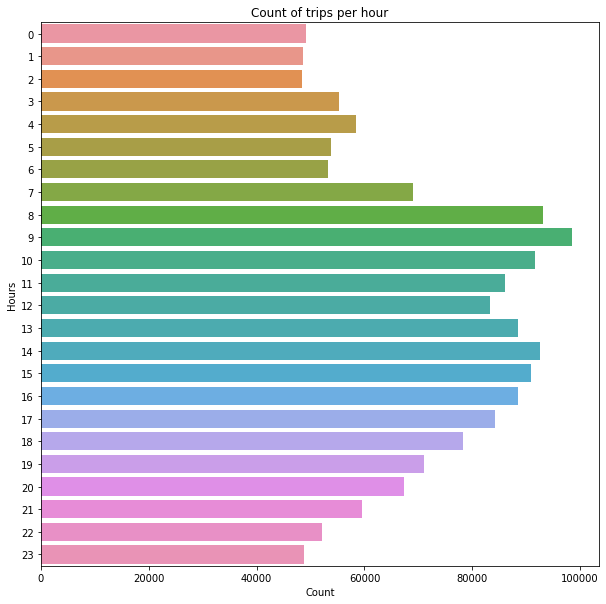

In [23]:
plt.figure(figsize = (10,10))
plt.title('Count of trips per hour')
sns.countplot(y = 'hour', data = df)
plt.xlabel('Count')
plt.ylabel('Hours')

In [24]:
df['MISSING_DATA'].value_counts()

False    1710660
True          10
Name: MISSING_DATA, dtype: int64

In [25]:
df.drop(df[df['MISSING_DATA'] == True].index, inplace = True)

For 10 instances the GPS data steam is not complete and there can be one or more locations missing. Such a data points wont gives us the appropriate trip time so we can drop such observations.

In [26]:
df['MISSING_DATA'].unique()

array([False])



Also some of the POLYLINES values are missing in which we cannot find the trip time, dropping such observations is also the good idea.


In [27]:
df[df['POLYLINE'] =='[]']['POLYLINE'].value_counts()

[]    5901
Name: POLYLINE, dtype: int64

In [28]:
df.drop(df[df['POLYLINE'] =='[]']['POLYLINE'].index, inplace = True)

In [29]:
df[df['POLYLINE'] =='[]']['POLYLINE'].value_counts()

Series([], Name: POLYLINE, dtype: int64)


**Convreting a POLYLINE into the total travelling time.**

In [30]:
df['Polyline Length'] = df['POLYLINE'].apply(lambda x : len(eval(x))-1)

In [31]:
df['Trip Time(sec)'] = df['Polyline Length'].apply(lambda x : x * 15)

In [32]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,year,month,month_day,hour,week_day,Polyline Length,Trip Time(sec)
577,1372636853620000380,C,NaN,NaN,20000380,1372636853,A,False,"[[-8.610291,41.140746],[-8.6103,41.140755],[-8...",2013,7,1,0,0,24,360
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013,7,1,0,0,42,630
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013,7,1,0,0,22,330
10,1372636875620000233,C,NaN,NaN,20000233,1372636875,A,False,"[[-8.619894,41.148009],[-8.620164,41.14773],[-...",2013,7,1,0,0,21,315
64,1372636896620000360,C,NaN,NaN,20000360,1372636896,A,False,"[[-8.617599,41.146137],[-8.617581,41.14593],[-...",2013,7,1,0,0,42,630


In [33]:
df['Trip Time(sec)'].describe()

count    1.704759e+06
mean     7.189021e+02
std      6.846122e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.000000e+02
75%      8.700000e+02
max      5.820000e+04
Name: Trip Time(sec), dtype: float64

In [34]:
df.groupby('week_day').mean()

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,year,month,month_day,hour,Polyline Length,Trip Time(sec)
week_day,,,,,,,,,,,,
0,1.388541e+18,24266.902923,29.906836,2.000034e+07,1.388541e+09,False,2013.489873,6.645881,15.831436,12.701853,50.161472,752.422087
1,1.388354e+18,24255.076873,30.345652,2.000035e+07,1.388354e+09,False,2013.477034,6.738722,15.530936,12.381605,48.920652,733.809787
2,1.388374e+18,24085.274571,30.195455,2.000034e+07,1.388374e+09,False,2013.508033,6.373327,15.530086,12.670080,49.710429,745.656429
3,1.388607e+18,24016.681072,30.156901,2.000035e+07,1.388607e+09,False,2013.507242,6.469796,15.584794,12.470284,49.189870,737.848052
4,1.388760e+18,24240.138819,30.093780,2.000035e+07,1.388760e+09,False,2013.504146,6.551442,15.979771,12.654915,50.307077,754.606154
5,1.388724e+18,25431.411644,30.651643,2.000035e+07,1.388724e+09,False,2013.493629,6.677032,15.702651,10.976918,44.273390,664.100848
6,1.388954e+18,25552.079126,30.557114,2.000036e+07,1.388954e+09,False,2013.504626,6.660169,14.911438,9.511842,42.771202,641.568025


In [35]:
df['DAY_TYPE'].isnull().sum()

0

In [36]:
df = pd.get_dummies(df, columns=['CALL_TYPE'])

In [37]:
df.shape

(1704759, 18)

In [38]:
df = df.drop_duplicates()
print(df.shape)

(1704757, 18)


In [39]:
df.to_csv('/content/drive/My Drive/taxi_trajectory_data/Cleaned_data.csv', index = None)

In [40]:
df = df.iloc[:100000]

In [41]:
df.shape

(100000, 18)

In [42]:
X = df[['Polyline Length', 'CALL_TYPE_A', 'CALL_TYPE_B', 'CALL_TYPE_C']]
y = df['Trip Time(sec)']

In [43]:
s = StandardScaler()
X = s.fit_transform(X)

In [44]:
print(np.mean(X))
np.std(X)

5.4853899200679736e-17


0.9999999999999998

In [45]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.3)

In [46]:
print("The size of training input is", X_train.shape)
print("The size of training output is", y_train.shape)
print(50 *'*')
print("The size of testing input is", X_test.shape)
print("The size of testing output is", y_test.shape)

The size of training input is (70000, 4)
The size of training output is (70000,)
**************************************************
The size of testing input is (30000, 4)
The size of testing output is (30000,)


### Machine Learning Models



**1. Baseline Model**



*   In baseline model the predicted trip time would be simply the average of all trip time.
*   We will use this baseline model to perform hypothesis testing for other ML complex models.



In [47]:
y_train_pred = np.ones(X_train.shape[0]) * y_train.mean() #Predicting the train results

In [48]:
y_test_pred = np.ones(y_test.shape[0]) * y_train.mean() #Predicting the test results

In [49]:
print("Train Results for Baseline Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Baseline Model:
--------------------------------------------------
Root mean squared error:  671.8328124063846
R-squared:  0.0


In [50]:
print("Test Results for Baseline Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for Baseline Model:
--------------------------------------------------
Root mean squared error:  633.6278444138611
R-squared:  -1.4837010436474785e-05


**2. KNN Regressor**

In [51]:
k_range  =list(range(1,30)) 
param =dict(n_neighbors =k_range)
knn_regressor =GridSearchCV(KNeighborsRegressor(),param,cv =10)
knn_regressor.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29]})

In [52]:
print(knn_regressor.best_estimator_)
knn_regressor.best_params_

KNeighborsRegressor(n_neighbors=2)


{'n_neighbors': 2}

In [53]:
y_train_pred =knn_regressor.predict(X_train) ##Predict train result
y_test_pred =knn_regressor.predict(X_test) ##Predict test result

In [54]:
print("Train Results for KNN Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for KNN Regressor Model:
--------------------------------------------------
Root mean squared error:  11.39668654854183
R-squared:  0.9997122371107043


In [55]:
print("Test Results for KNN Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for KNN Regressor Model:
--------------------------------------------------
Root mean squared error:  20.208429553035536
R-squared:  0.9989828076966574


**3. Ridge Regressor**

In [56]:
params ={'alpha' :[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
ridge_regressor =GridSearchCV(Ridge(), params ,cv =5,scoring = 'neg_mean_absolute_error', n_jobs =-1)
ridge_regressor.fit(X_train ,y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]},
             scoring='neg_mean_absolute_error')

In [57]:
print(ridge_regressor.best_estimator_)
ridge_regressor.best_params_

Ridge(alpha=0.0001)


{'alpha': 0.0001}

In [58]:
y_train_pred =ridge_regressor.predict(X_train) ##Predict train result
y_test_pred =ridge_regressor.predict(X_test) ##Predict test result

In [59]:
print("Train Results for Ridge Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Ridge Regressor Model:
--------------------------------------------------
Root mean squared error:  9.314054282527773e-07
R-squared:  1.0


In [60]:
print("Test Results for Ridge Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for Ridge Regressor Model:
--------------------------------------------------
Root mean squared error:  8.780380627340071e-07
R-squared:  1.0


**4. Lasso Regression**

In [61]:
params ={'alpha' :[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
lasso_regressor =GridSearchCV(Lasso(), params ,cv =15,scoring = 'neg_mean_absolute_error', n_jobs =-1)
lasso_regressor.fit(X_train ,y_train)

GridSearchCV(cv=15, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]},
             scoring='neg_mean_absolute_error')

In [62]:
print(lasso_regressor.best_estimator_)
lasso_regressor.best_params_

Lasso(alpha=0.0001)


{'alpha': 0.0001}

In [63]:
y_train_pred =lasso_regressor.predict(X_train) ##Predict train result
y_test_pred =lasso_regressor.predict(X_test) ##Predict test result

In [64]:
print("Train Results for Lasso Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Lasso Regressor Model:
--------------------------------------------------
Root mean squared error:  9.832847495975917e-05
R-squared:  0.9999999999999786


In [65]:
print("Test Results for Lasso Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for Lasso Regressor Model:
--------------------------------------------------
Root mean squared error:  9.273685131350477e-05
R-squared:  0.9999999999999786


**5. Decision Tree Regressor**

In [66]:
depth  =list(range(3,30))
param_grid =dict(max_depth =depth)
tree =GridSearchCV(DecisionTreeRegressor(),param_grid,cv =10)
tree.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                       25, 26, 27, 28, 29]})

In [67]:
print(tree.best_estimator_)
tree.best_params_

DecisionTreeRegressor(max_depth=12)


{'max_depth': 12}

In [68]:
y_train_pred =tree.predict(X_train) ##Predict train result
y_test_pred =tree.predict(X_test) ##Predict test result

In [69]:
print("Train Results for Decision Tree Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Decision Tree Regressor Model:
--------------------------------------------------
Root mean squared error:  0.0
R-squared:  1.0


In [70]:
print("Test Results for Decision Tree Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for Decision Tree Regressor Model:
--------------------------------------------------
Root mean squared error:  29.04931152368331
R-squared:  0.9978981117429863


**6. XGBoost**

In [71]:
tuned_params = {'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 200, 300, 400, 500], 'reg_lambda': [0.001, 0.1, 1.0, 10.0, 100.0]}
model = RandomizedSearchCV(XGBRegressor(), tuned_params, n_iter=20, scoring = 'neg_mean_absolute_error', cv=5, n_jobs=-1)
model.fit(X_train, y_train)

[13:55:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_lambda': [0.001, 0.1, 1.0, 10.0,
                                                       100.0]},
                   scoring='neg_mean_absolute_error')

In [72]:
print(model.best_estimator_)
model.best_params_

XGBRegressor(learning_rate=0.05, max_depth=5, n_estimators=400, reg_lambda=0.1)


{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 400, 'reg_lambda': 0.1}

In [73]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [74]:
print("Train Results for XGBoost Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for XGBoost Regressor Model:
--------------------------------------------------
Root mean squared error:  0.18135832367218682
R-squared:  0.9999999271293634


In [75]:
print("Test Results for XGBoost Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for XGBoost Regressor Model:
--------------------------------------------------
Root mean squared error:  27.200513065843573
R-squared:  0.9981571409157688


**7. Random Forest Regressor**

In [76]:
tuned_params = {'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
random_regressor = RandomizedSearchCV(RandomForestRegressor(), tuned_params, n_iter = 20, scoring = 'neg_mean_absolute_error', cv = 5, n_jobs = -1)
random_regressor.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   scoring='neg_mean_absolute_error')

In [77]:
print(random_regressor.best_estimator_)
random_regressor.best_params_

RandomForestRegressor(n_estimators=400)


{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}

In [78]:
y_train_pred = random_regressor.predict(X_train)
y_test_pred = random_regressor.predict(X_test)

In [79]:
print("Train Results for Random Forest Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Random Forest Regressor Model:
--------------------------------------------------
Root mean squared error:  7.176411917917266
R-squared:  0.999885898252588


In [80]:
print("Test Results for Random Forest Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for Random Forest Regressor Model:
--------------------------------------------------
Root mean squared error:  27.849310548299496
R-squared:  0.9980681792259454


**8. Stacking**

In [81]:
# Initializing models
ridge = Ridge()
lasso = Lasso()
tree = DecisionTreeRegressor()
knn = KNeighborsRegressor()

stack = StackingRegressor(regressors = [ridge, lasso, knn], meta_regressor = tree)
stack.fit(X_train, y_train)

StackingRegressor(meta_regressor=DecisionTreeRegressor(),
                  regressors=[Ridge(), Lasso(), KNeighborsRegressor()])

In [82]:
print(stack.regr_)
stack.meta_regr_

[Ridge(), Lasso(), KNeighborsRegressor()]


DecisionTreeRegressor()

In [83]:
y_train_pred = stack.predict(X_train)
y_test_pred = stack.predict(X_test)

In [84]:
print("Train Results for Stacking Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Stacking Regressor Model:
--------------------------------------------------
Root mean squared error:  0.0
R-squared:  1.0


In [86]:
print("Test Results for Stacking Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for Stacking Regressor Model:
--------------------------------------------------
Root mean squared error:  28.860093554941916
R-squared:  0.9979254046260996
